In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

In [ ]:
diabetes_data.info()

- 로지스틱 회귀를 이용해 예측을 수행하고 앞 예제에서 사용한 유틸리티 함수인 get_clf_eval(), get_eval_by_thresholds(), precision_recall_curve_plot()을 이용해 성능평가지표를 출력, 재현율 곡선을 시각화

In [62]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도:{1: .4f}, 재현율:{2: .4f}, f1점수: {3: .4f}, AUC점수:{4: .4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [63]:
X  = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=156, stratify=y)

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]


get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[88 12]
 [22 32]]
정확도: 0.7792, 정밀도: 0.7273, 재현율: 0.5926, f1점수:  0.6531, AUC점수: 0.8437


- 전체 데이터 중 65%가 Negative이므로 정확도보다는 재현율 성능에 조금 더 초점 -> precision_recall_curve_plot()

In [ ]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0: threshold_boundary], label='recall')

    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

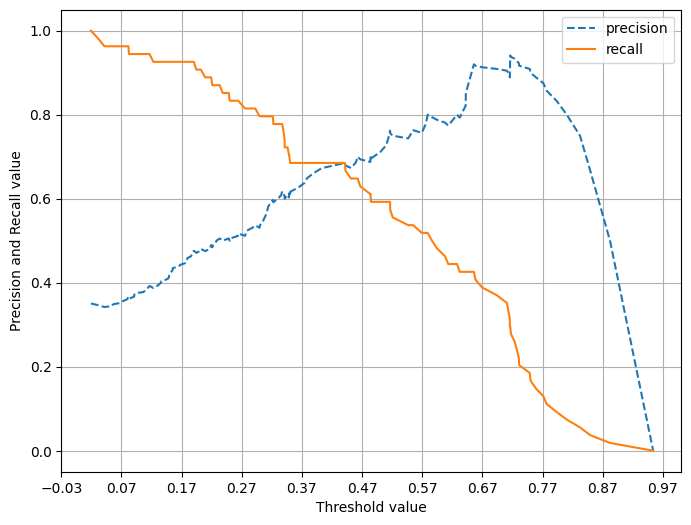

In [25]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

In [26]:
diabetes_data.describe() #min이 0인 피처가 존재, 포도당 수치는 0일 수 없음

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


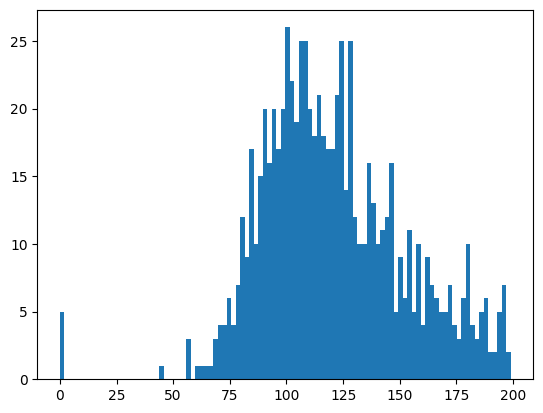

In [28]:
plt.hist(diabetes_data['Glucose'], bins=100)
plt.show() #0값이 5개

- 0값이 있는 피처들과 퍼센트 계산

In [29]:
#0값을 검사할 피처명 리스트
zero_features = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

#전체 데이터 건 수
total_count = diabetes_data['Glucose'].count()

#피처별로 반복하면서 데이터값이 0인 데이터 건수를 추출하고 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
    print('{0} 0건수는 {1}, 퍼센트는 {2: .2f}%'.format(feature, zero_count, 100*zero_count/total_count)) 

Glucose 0건수는 5, 퍼센트는  0.65%
BloodPressure 0건수는 35, 퍼센트는  4.56%
SkinThickness 0건수는 227, 퍼센트는  29.56%
Insulin 0건수는 374, 퍼센트는  48.70%
BMI 0건수는 11, 퍼센트는  1.43%


- 0값을 평균값들로 대체

In [30]:
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features)


In [65]:
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

#StandarfScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

#로지스틱 회귀로 학습, 예측 및 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, f1점수:  0.6804, AUC점수: 0.8433


- 재현율 수치를 개선하기 위해 임곗값 변화시키면서 확인 -> get_eval_by_threshold()

In [60]:
from sklearn.preprocessing import Binarizer


def get_eval_by_threshold(y_test, pred_proba_c1, threshold):
    #thresholds list 객체 내의 값을 차례로 평가
    for custom_threshold in threshold:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값:', custom_threshold)
        get_clf_eval(y_test, pred = custom_predict, pred_proba=pred_proba_c1)

In [61]:
thresholds = [0.3, 0.33, 0.36, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임계값: 0.3
오차행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963, f1점수:  0.6615, AUC점수: 0.8433
임계값: 0.33
오차행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778, f1점수:  0.6774, AUC점수: 0.8433
임계값: 0.36
오차행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222, f1점수:  0.6667, AUC점수: 0.8433
임계값: 0.42
오차행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667, f1점수:  0.6792, AUC점수: 0.8433
임계값: 0.45
오차행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667, f1점수:  0.6857, AUC점수: 0.8433
임계값: 0.48
오차행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, f1점수:  0.6931, AUC점수: 0.8433
임계값: 0.5
오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, f1점수:  0.6804, AUC점수: 0.8433


- predict() 메서드는 임곗값을 마음대로 변환 X => Binarizer클래스를 이용해 predict_proba()로 추출한 예측 결과확률값을 변환해 변경된 임계갓ㅂ에 따른 예측 클래스 값

In [56]:
#임계값을 0.48로 설정한 Binarizer생성
binarizer = Binarizer(threshold=0.48)
#위에서 구현한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarize 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))

get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

오차행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, f1점수:  0.6931, AUC점수: 0.8433
